# Evaluate Final Model

## Initialize notebook

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import tensorflow as tf

# Read in data
DATA_PATH_PROC = "/content/drive/MyDrive/DATASCI 207/Final Project/NBA data - processed"

## Load model and data

In [ ]:
# Load model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/DATASCI 207/Final Project/best_model.keras')

# Load model history
with open('/content/drive/MyDrive/DATASCI 207/Final Project/best_model_fit.pkl', 'rb') as f:
    best_model_fit = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Import data
odds_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_train.csv"))
odds_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_val.csv"))
odds_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_test.csv"))
X_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_train.csv"))
X_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_val.csv"))
X_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_test.csv"))
y_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_train.csv"))
y_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_val.csv"))
y_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_test.csv"))

# Drop 2012-13 data, as it does not have good previous seasons to calibrate
X_train = X_train[X_train['season'] != '2012-13']
y_train = y_train.loc[X_train.index]
odds_train = odds_train.loc[X_train.index]

# Drop non-numeric and ID features
X_train = X_train.drop(['season'], axis = 1)
X_val = X_val.drop(['season'], axis = 1)
X_test = X_test.drop(['season'], axis = 1)

# Separate actual and Vegas spreads
y_train, y_train_vegas, y_train_class = y_train['spread'], y_train['vegas_spread'], y_train['covered_spread']
y_val, y_val_vegas, y_val_class = y_val['spread'], y_val['vegas_spread'], y_val['covered_spread']
y_test, y_test_vegas, y_test_class = y_test['spread'], y_test['vegas_spread'], y_test['covered_spread']

## Assess model performance

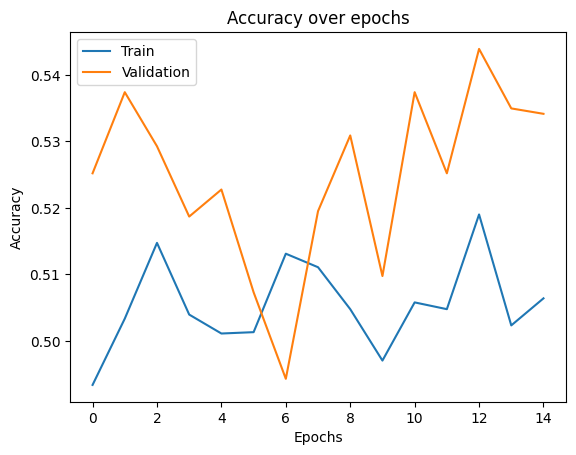

In [ ]:
# Plot training performance
fig, ax = plt.subplots()
ax.plot(best_model_fit['accuracy'])
ax.plot(best_model_fit['val_accuracy'])
ax.set_title('Accuracy over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], fontsize=10)
plt.show()

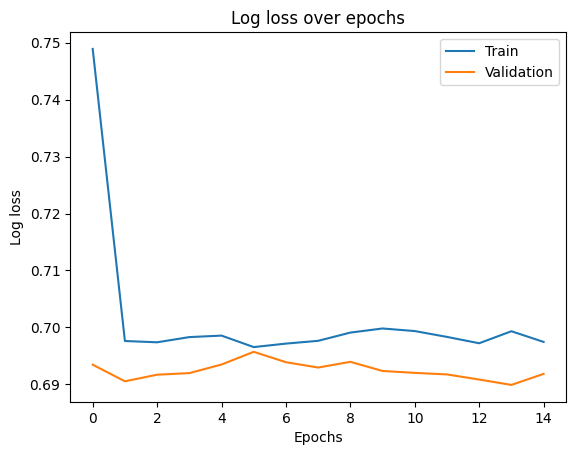

In [ ]:
# Plot training performance
fig, ax = plt.subplots()
ax.plot(best_model_fit['loss'])
ax.plot(best_model_fit['val_loss'])
ax.set_title('Log loss over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Log loss')
ax.legend(['Train', 'Validation'], fontsize=10)
plt.show()

In [ ]:
# Print results
print("Training accuracy:", best_model.evaluate(x = X_train, y = y_train_class)[1])
print("Validation accuracy:", best_model.evaluate(x = X_val, y = y_val_class)[1])

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5195 - loss: 0.6926
Training accuracy: 0.5133211016654968
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5192 - loss: 0.6946 
Validation accuracy: 0.5341463685035706


## Calculate returns

### Baseline

In [ ]:
# Column bind probabilities and odds
returns_base_df = pd.concat([odds_val, pd.DataFrame(y_val_class, columns = ['covered_spread'])], axis = 1)
returns_base_df['adj_win_prob'] = np.full(shape = odds_val.shape[0], fill_value = 0.5)
returns_base_df['covered_spread_bet'] = np.full(shape = odds_val.shape[0], fill_value = 1)

# Calculate adjusted win prob. based on bet
returns_base_df['kelly_wager'] = 100 * (returns_base_df['adj_win_prob'] - (1 - returns_base_df['adj_win_prob']) / returns_base_df['spread_odds'])
returns_base_df.loc[returns_base_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_base_df['return'] = returns_base_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total validation return:", returns_base_df['return'].sum())
print("Over number of games:", returns_base_df.shape[0])
print("Percent validation return:", returns_base_df['return'].sum() / returns_base_df['kelly_wager'].sum())
print("Average validation return:", returns_base_df['return'].sum()/returns_base_df.shape[0])

Total validation return: 0.0
Over number of games: 1230
Percent validation return: nan
Average validation return: 0.0


<ipython-input-8-136967a7bf58>:14: RuntimeWarning: invalid value encountered in scalar divide
  print("Percent validation return:", returns_base_df['return'].sum() / returns_base_df['kelly_wager'].sum())


### Training

In [ ]:
# Column bind probabilities and odds
y_pred_train = best_model.predict(X_train)
returns_train_df = pd.concat([odds_train, pd.DataFrame(y_pred_train, columns = ['prob']), pd.DataFrame(y_train_class, columns = ['covered_spread'])], axis = 1)
returns_train_df['covered_spread_bet'] = returns_train_df.apply(lambda row: 1 if row['prob'] > 0.5 else 0, axis=1)

# Calculate adjusted win prob. based on bet
returns_train_df['adj_win_prob'] = returns_train_df.apply(lambda row: row['prob'] if row['prob'] > 0.5 else 1 - row['prob'], axis=1)
returns_train_df['kelly_wager'] = 100 * (returns_train_df['adj_win_prob'] - (1 - returns_train_df['adj_win_prob']) / returns_train_df['spread_odds'])
returns_train_df.loc[returns_train_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_train_df['return'] = returns_train_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total training return:", returns_train_df['return'].sum())
print("Over number of games:", returns_train_df.shape[0])
print("Percent training return:", returns_train_df['return'].sum() / returns_train_df['kelly_wager'].sum())
print("Average training return:", returns_train_df['return'].sum()/returns_train_df.shape[0])

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Total training return: 5691.827215354288
Over number of games: 6104
Percent training return: 0.4389715492932752
Average training return: 0.9324749697500471


### Validation

In [ ]:
# Column bind probabilities and odds
y_pred_val = best_model.predict(X_val)
returns_val_df = pd.concat([odds_val, pd.DataFrame(y_pred_val, columns = ['prob']), pd.DataFrame(y_val_class, columns = ['covered_spread'])], axis = 1)
returns_val_df['covered_spread_bet'] = returns_val_df.apply(lambda row: 1 if row['prob'] > 0.5 else 0, axis=1)

# Calculate adjusted win prob. based on bet
returns_val_df['adj_win_prob'] = returns_val_df.apply(lambda row: row['prob'] if row['prob'] > 0.5 else 1 - row['prob'], axis=1)
returns_val_df['kelly_wager'] = 100 * (returns_val_df['adj_win_prob'] - (1 - returns_val_df['adj_win_prob']) / returns_val_df['spread_odds'])
returns_val_df.loc[returns_val_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_val_df['return'] = returns_val_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total validation return:", returns_val_df['return'].sum())
print("Over number of games:", returns_val_df.shape[0])
print("Percent validation return:", returns_val_df['return'].sum() / returns_val_df['kelly_wager'].sum())
print("Average validation return:", returns_val_df['return'].sum()/returns_val_df.shape[0])

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total validation return: 2611.4738014386007
Over number of games: 1230
Percent validation return: 0.5680078555071643
Average validation return: 2.123149432063903


### Test

In [ ]:
# Column bind probabilities and odds
y_pred_test = best_model.predict(X_test)
returns_test_df = pd.concat([odds_val, pd.DataFrame(y_pred_val, columns = ['prob']), pd.DataFrame(y_test_class, columns = ['covered_spread'])], axis = 1)
returns_test_df['covered_spread_bet'] = returns_test_df.apply(lambda row: 1 if row['prob'] > 0.5 else 0, axis=1)

# Calculate adjusted win prob. based on bet
returns_test_df['adj_win_prob'] = returns_test_df.apply(lambda row: row['prob'] if row['prob'] > 0.5 else 1 - row['prob'], axis=1)
returns_test_df['kelly_wager'] = 100 * (returns_test_df['adj_win_prob'] - (1 - returns_test_df['adj_win_prob']) / returns_test_df['spread_odds'])
returns_test_df.loc[returns_test_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_test_df['return'] = returns_test_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total validation return:", returns_test_df['return'].sum())
print("Over number of games:", returns_test_df.shape[0])
print("Percent validation return:", returns_test_df['return'].sum() / returns_test_df['kelly_wager'].sum())
print("Average validation return:", returns_test_df['return'].sum()/returns_test_df.shape[0])

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Total validation return: 2143.696002149993
Over number of games: 1230
Percent validation return: 0.4662639802741775
Average validation return: 1.742842278170726
